In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.vision.learner import _add_norm

In [2]:
train_df = pd.read_csv('train.csv')
train_df = train_df[~train_df['image_id'].isin(['1562043567.jpg', '3551135685.jpg', '2252529694.jpg'])]

In [3]:
path = Path('')

In [4]:
def get_x(r):
    return path/'train_images'/r['image_id']

def get_y(r):
    return r['label']

In [5]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=112, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=get_x,
                 get_y=get_y,
                 splitter=RandomSplitter(0.1, seed=42),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(train_df, bs=bs)

In [6]:
from torch.distributions.beta import Beta

# Cell
def reduce_loss(loss, reduction='mean'):
    "Reduce the loss based on `reduction`"
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

# Cell
class MixHandler(Callback):
    "A handler class for implementing `MixUp` style scheduling"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.5):
        self.distrib = Beta(tensor(alpha), tensor(alpha))

    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.loss_func

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))
    
class CutMix(MixHandler):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    def __init__(self, alpha=1., **kwargs): super().__init__(alpha, **kwargs)
    def before_batch(self):
        bs, _, H, W = self.x.size()
        self.lam = self.distrib.sample((1,))
        shuffle = torch.randperm(bs)
        xb1,self.yb1 = self.x[shuffle], tuple((self.y[shuffle],))
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][..., y1:y2, x1:x2] = xb1[..., y1:y2, x1:x2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long)
        cut_h = torch.round(H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,))
        cy = torch.randint(0, H, (1,))
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

In [7]:
loss_func = LabelSmoothingCrossEntropy()

In [9]:
cbs=[GradientAccumulation(), CutMix(), ReduceLROnPlateau(), 
     SaveModelCallback(monitor='accuracy', comp=np.greater, fname='resnet50_112'), 
     EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.001, patience=4)]

In [10]:
learn = cnn_learner(dls, resnet50, metrics= [accuracy], loss_func=loss_func, opt_func=ranger).to_native_fp16()

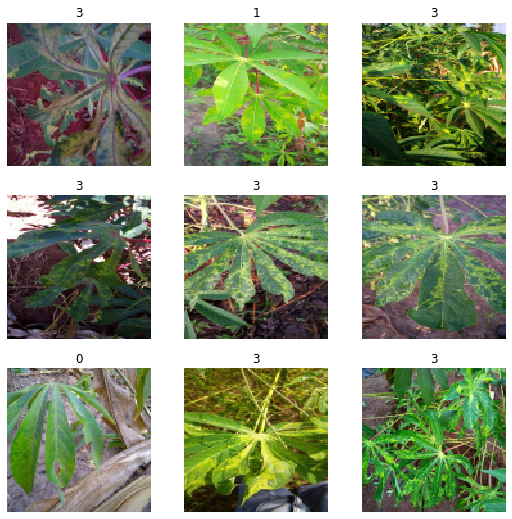

In [11]:
dls.show_batch()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.14454397559165955)

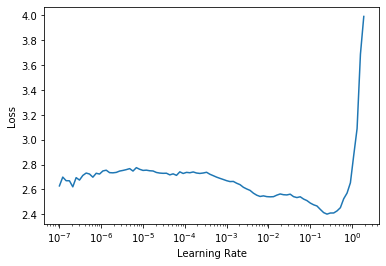

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.274213,1.114980,0.682562,01:40
1,1.243898,1.629407,0.699392,01:39
2,1.214891,1.379368,0.687705,01:40
3,1.169637,1.036141,0.701730,01:39
4,1.072762,0.975589,0.740065,01:39


Better model found at epoch 0 with accuracy value: 0.6825619339942932.
Epoch 1: reducing lr to 0.001
Better model found at epoch 1 with accuracy value: 0.6993922591209412.
Epoch 2: reducing lr to 0.001
Better model found at epoch 3 with accuracy value: 0.7017297744750977.
Better model found at epoch 4 with accuracy value: 0.7400654554367065.


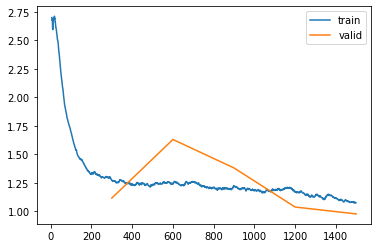

In [13]:
learn.fit_flat_cos(5,1e-2, cbs=cbs)
learn.recorder.plot_loss()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=1.9054607491852948e-06)

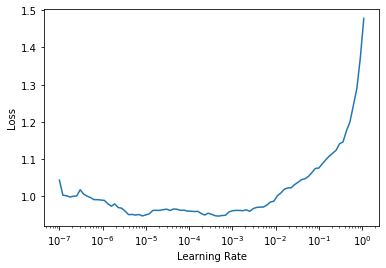

In [15]:
learn.unfreeze()
learn.lr_find()

In [16]:
learn.fit_flat_cos(20,1e-4, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,1.055638,1.081437,0.752688,01:59
1,1.020352,0.933098,0.741468,01:59
2,0.975907,0.920122,0.745676,01:59
3,0.984238,0.865063,0.763441,01:58
4,0.978610,0.874604,0.758766,01:58
5,0.916247,0.860035,0.775596,01:58
6,0.946980,0.843468,0.783076,01:59
7,0.904025,0.842830,0.780739,01:59
8,0.924682,0.865969,0.782609,01:59
9,0.917778,0.866927,0.773726,01:59


Better model found at epoch 0 with accuracy value: 0.7526881694793701.
Better model found at epoch 3 with accuracy value: 0.7634408473968506.
Epoch 4: reducing lr to 1e-05
Better model found at epoch 5 with accuracy value: 0.7755960822105408.
Better model found at epoch 6 with accuracy value: 0.7830762267112732.
Epoch 8: reducing lr to 1e-05
Epoch 9: reducing lr to 1e-05
No improvement since epoch 6: early stopping


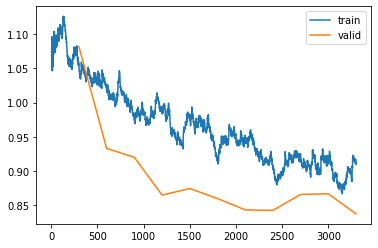

In [17]:
learn.recorder.plot_loss()

In [19]:
learn.load('resnet50_112')

/home/bf/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
cbs=[GradientAccumulation(), CutMix(), ReduceLROnPlateau(), 
     SaveModelCallback(monitor='accuracy', comp=np.greater, fname='resnet50_224'), 
     EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.001, patience=4)]

In [20]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=get_x,
                 get_y=get_y,
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(train_df, bs=bs)

In [21]:
learn.dls = dls

In [22]:
learn.fit_flat_cos(10,1e-4, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.905971,0.769710,0.827022,05:12
1,0.861343,0.742515,0.833333,05:11
2,0.859942,0.748812,0.827022,05:11
3,0.822117,0.722457,0.841047,05:11
4,0.833305,0.716799,0.844320,05:11
5,0.810994,0.713897,0.843852,05:11
6,0.807335,0.754954,0.842683,05:11
7,0.796605,0.710187,0.845489,05:11
8,0.783113,0.693893,0.849229,05:11
9,0.753738,0.679675,0.860449,05:11


Better model found at epoch 0 with accuracy value: 0.8270219564437866.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.
Epoch 2: reducing lr to 1e-05
Better model found at epoch 3 with accuracy value: 0.8410472273826599.
Better model found at epoch 4 with accuracy value: 0.844319760799408.
Epoch 6: reducing lr to 1e-05
Better model found at epoch 7 with accuracy value: 0.8454885482788086.
Better model found at epoch 8 with accuracy value: 0.8492286205291748.
Better model found at epoch 9 with accuracy value: 0.8604488372802734.


In [23]:
learn.unfreeze()

In [24]:
learn.fit_flat_cos(20,1e-6, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.726570,0.676755,0.862786,05:11
1,0.743063,0.674610,0.862319,05:11
2,0.731189,0.680304,0.857877,05:11
3,0.751646,0.676255,0.863254,05:11
4,0.749308,0.675385,0.863955,05:11
5,0.774353,0.675502,0.861384,05:11
6,0.741252,0.675166,0.861384,05:11
7,0.736859,0.674034,0.862085,05:11
8,0.758515,0.681082,0.855306,05:11


Better model found at epoch 0 with accuracy value: 0.8627863526344299.
Epoch 2: reducing lr to 1e-07
Epoch 3: reducing lr to 1e-07
Better model found at epoch 3 with accuracy value: 0.8632538318634033.
Epoch 4: reducing lr to 1e-07
Better model found at epoch 4 with accuracy value: 0.8639551401138306.
Epoch 5: reducing lr to 1e-07
Epoch 6: reducing lr to 1e-07
Epoch 8: reducing lr to 1e-07
No improvement since epoch 4: early stopping


In [19]:
# import timm
# #timm.list_models()[:10]
# timm.list_models('*efficientnet*')[:10]

In [20]:
#learn.save('resnet50_224')

Path('models/resnet50_224.pth')

In [8]:
learn.load('resnet50_224')

In [26]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=384, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=get_x,
                 get_y=get_y,
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(train_df, bs=bs)

In [42]:
cbs=[GradientAccumulation(), CutMix(), ReduceLROnPlateau(), 
     SaveModelCallback(monitor='accuracy',comp=np.greater, fname='resnet50_384'), 
     EarlyStoppingCallback(monitor='accuracy',comp=np.greater, min_delta=0.001, patience=4)]

In [28]:
learn.dls = dls

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=8.31763736641733e-06)

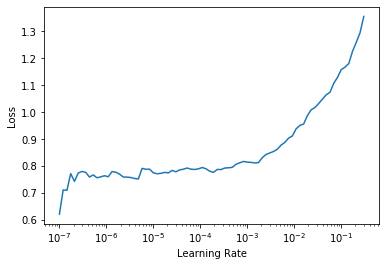

In [29]:
learn.lr_find()

In [43]:
learn.unfreeze()
learn.fit_flat_cos(20,1e-6, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.786999,0.686469,0.854839,13:15
1,0.806149,0.683707,0.857176,13:20
2,0.786557,0.680801,0.861384,13:22
3,0.801472,0.677065,0.858813,13:22
4,0.751534,0.676635,0.860916,13:24
5,0.808386,0.679540,0.860215,13:23
6,0.779704,0.676598,0.863020,13:24
7,0.768600,0.681243,0.863020,13:24
8,0.760634,0.675037,0.863020,13:25
9,0.791269,0.683033,0.857176,13:24


Better model found at epoch 0 with accuracy value: 0.8548387289047241.
Better model found at epoch 1 with accuracy value: 0.8571762442588806.
Better model found at epoch 2 with accuracy value: 0.8613837957382202.
Epoch 5: reducing lr to 1e-07
Better model found at epoch 6 with accuracy value: 0.863020122051239.
Epoch 7: reducing lr to 1e-07
Epoch 9: reducing lr to 1e-07
Better model found at epoch 10 with accuracy value: 0.8648901581764221.
Epoch 11: reducing lr to 1e-07
Better model found at epoch 12 with accuracy value: 0.8697989583015442.
Epoch 13: reducing lr to 1e-07
Epoch 14: reducing lr to 1e-07
Epoch 15: reducing lr to 9.046821382737325e-08
Epoch 16: reducing lr to 6.54791379359852e-08
No improvement since epoch 12: early stopping


In [44]:
learn.load('resnet50_384')

In [ ]:
learn = learn.to_native_fp32()

In [ ]:
submission_df = pd.read_csv('sample_submission.csv')
submission_df.head()

In [ ]:
test_data_path = submission_df['image_id'].apply(lambda x: path/'test_images'/x)
tst_dl = learn.dls.test_dl(test_data_path)
predictions = learn.tta(dl = tst_dl, n=10)

submission_df['label'] = np.argmax(predictions[0],axis=1)
submission_df

In [ ]:
submission_df.shape

In [ ]:
submission_df.to_csv('submission.csv',index=False)